In [1]:
file_path = '/Users/fabricesashinkumar/Downloads/Question1 Data.xlsx'

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime

data = pd.read_excel(file_path, sheet_name='1')

data['Dates'] = pd.to_datetime(data['Dates']) 
data.set_index('Dates', inplace=True)

data['FTSE Log Returns'] = data['FTSE Log Returns'].replace([np.inf, -np.inf], np.nan)
data.dropna(subset=['FTSE Log Returns'], inplace=True)

data['Scaled Returns'] = data['FTSE Log Returns'] * 100

# Create 1-month lag for NASDAQ Returns
data['NASDAQ Returns Lagged'] = data['NASDAQ Returns'].shift(1)

required_columns = ['NASDAQ Returns Lagged', 'interest rate and m2 interaction']
if not all(col in data.columns for col in required_columns):
    raise ValueError("Missing one or more required columns for exogenous variables.")

data.dropna(subset=required_columns, inplace=True)

# Split Data
data.dropna(subset=required_columns + ['Scaled Returns'], inplace=True)

train_data = data[data.index <= datetime(2014, 10, 31)]['Scaled Returns']
test_data = data[data.index > datetime(2014, 10, 31)]['Scaled Returns']
exog_vars_mean = data[required_columns]
exog_train_mean = exog_vars_mean.loc[train_data.index]
exog_test_mean = exog_vars_mean.loc[test_data.index]

# Print Summary for Verification
print("Data Summary:")
print(data.describe())

print("\nMissing Values:")
print(data.isnull().sum())

print("\nTraining Data:")
print(train_data.head())

print("\nTesting Data:")
print(test_data.head())

Data Summary:
       FTSE Log Returns  1month_bond  Monthly Interest Rates   Inflation  \
count        344.000000   344.000000              344.000000  344.000000   
mean           0.002604     0.002380                0.002419    0.016691   
std            0.039323     0.002054                0.002036    0.033202   
min           -0.167382    -0.000021                0.000083   -0.075000   
25%           -0.016966     0.000363                0.000417    0.000000   
50%            0.008536     0.002944                0.002917    0.016667   
75%            0.027914     0.004309                0.004375    0.033333   
max            0.117132     0.006208                0.006250    0.208333   

       10year_bond  5year_bond  RetailSales Returns  1month_10year_bondspread  \
count   344.000000  344.000000           344.000000                344.000000   
mean      0.002989    0.002694             0.002871                 -0.000609   
std       0.001575    0.001795             0.019675       

ADF Statistic: -18.010074728728323
p-value: 2.7164076102910445e-30
The data is stationary (reject null hypothesis).


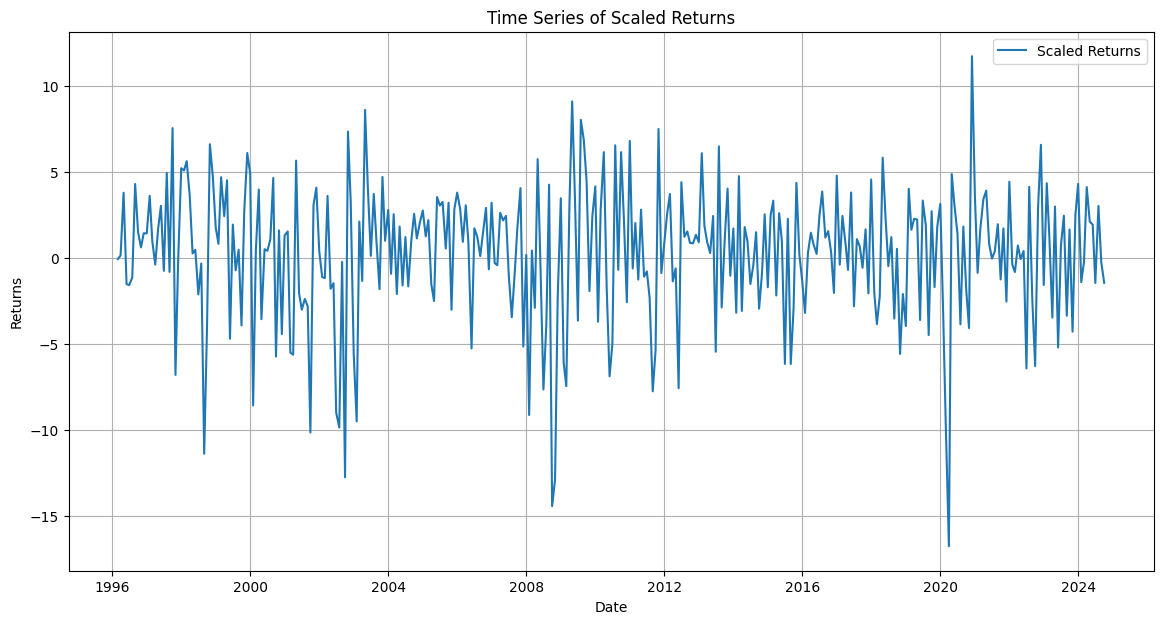

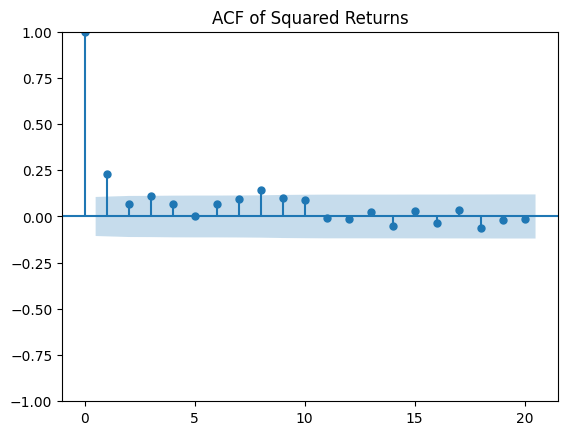

ARCH Test Statistic: 28.482957612903274
p-value: 0.0015100877969774383
Significant ARCH effects detected (reject null hypothesis).
Kurtosis: 1.7705321498750957
Skewness: -0.8498510888378901


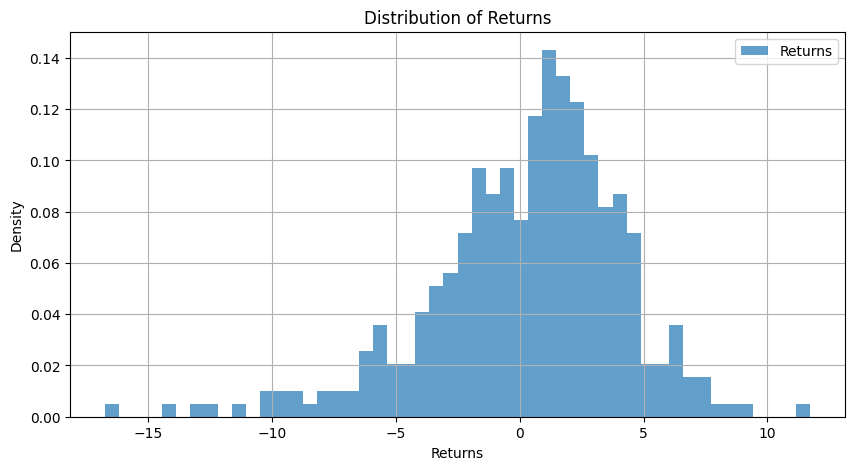

     lb_stat  lb_pvalue
10  6.526193   0.769289


In [21]:
# Stationarity Check (ADF Test)
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['Scaled Returns'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("The data is stationary (reject null hypothesis).")
else:
    print("The data is non-stationary (fail to reject null hypothesis).")

# Volatility Clustering    
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['Scaled Returns'], label="Scaled Returns")
plt.title("Time Series of Scaled Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid()
plt.show()

# Autocorrelation in Squared Returns
from statsmodels.graphics.tsaplots import plot_acf

squared_returns = data['Scaled Returns']**2
plot_acf(squared_returns, lags=20)
plt.title("ACF of Squared Returns")
plt.show()


# Presence of conditional heteroskedasticity
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(data['Scaled Returns'])
print(f"ARCH Test Statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")

if arch_test[1] < 0.05:
    print("Significant ARCH effects detected (reject null hypothesis).")
else:
    print("No significant ARCH effects detected (fail to reject null hypothesis).")
    
    
# K & S and Distribution of returns - Check if returns exhibit heavy tails (leptokurtosis)
from scipy.stats import kurtosis, skew

kurt = kurtosis(data['Scaled Returns'])
skewness = skew(data['Scaled Returns'])
print(f"Kurtosis: {kurt}")
print(f"Skewness: {skewness}")

plt.figure(figsize=(10, 5))
plt.hist(data['Scaled Returns'], bins=50, density=True, alpha=0.7, label="Returns")
plt.title("Distribution of Returns")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.grid()
plt.legend()
plt.show()

# checks for autocorrelation in the residuals of a mean model
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box = acorr_ljungbox(data['Scaled Returns'], lags=[10], return_df=True)
print(ljung_box)


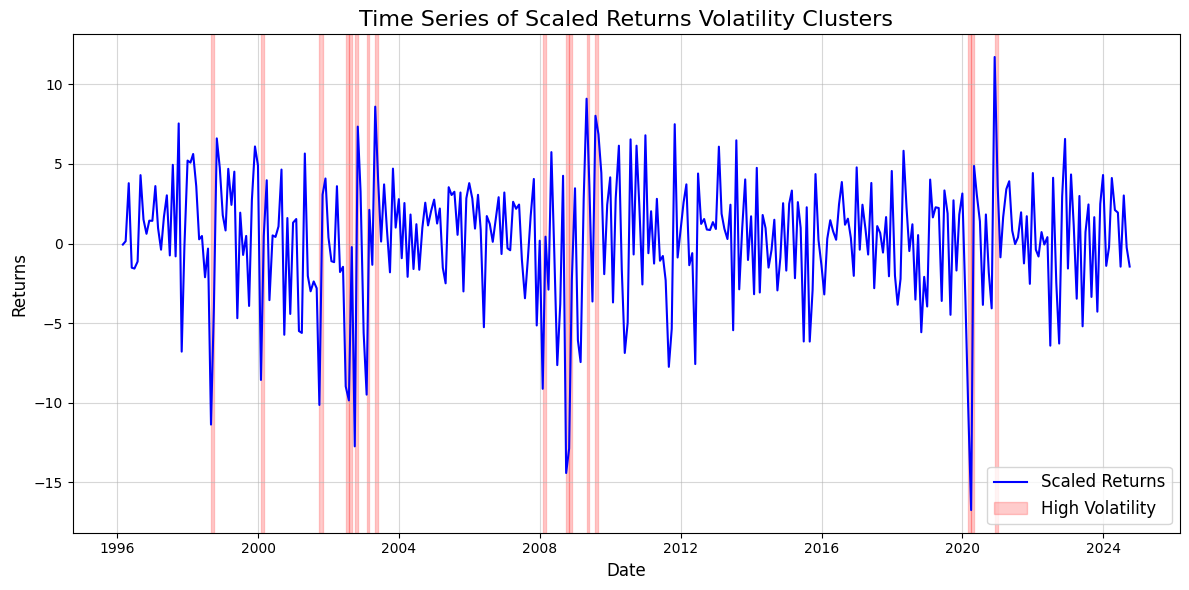

In [23]:
threshold = data['Scaled Returns'].std() * 2  # 2 standard deviations

high_volatility = (data['Scaled Returns'].abs() > threshold)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Scaled Returns'], label="Scaled Returns", color='blue')

# Highlight clusters
for start, end in zip(data.index[:-1], data.index[1:]):
    if high_volatility[start]:
        plt.axvspan(start, end, color='red', alpha=0.2, label='High Volatility' if 'High Volatility' not in plt.gca().get_legend_handles_labels()[1] else None)

# Add title, labels, and legend
plt.title("Time Series of Scaled Returns Volatility Clusters", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

# Save the plot
#plt.savefig("time_series_scaled_returns_vol.png", dpi=300)

# Show the plot
#plt.show()

In [25]:
from arch.univariate import HARX, EGARCH, StudentsT, Normal

model = HARX(y=train_data, x=exog_train_mean, lags=1)  # lags=0 indicates no autoregressive terms in mean
model.volatility = EGARCH(p=1, o=1, q=1)
model.distribution = Normal()  # Use the Student's t-distribution

# Fit the model
egarch_fit = model.fit(disp="off")

# Print summary
print(egarch_fit.summary())

                         HAR-X - EGARCH Model Results                         
Dep. Variable:         Scaled Returns   R-squared:                       0.506
Mean Model:                     HAR-X   Adj. R-squared:                  0.499
Vol Model:                     EGARCH   Log-Likelihood:               -541.344
Distribution:                  Normal   AIC:                           1098.69
Method:            Maximum Likelihood   BIC:                           1125.98
                                        No. Observations:                  224
Date:                Mon, Nov 25 2024   Df Residuals:                      220
Time:                        15:12:08   Df Model:                            4
                                             Mean Model                                             
                                       coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------------------